In [76]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pprint as pprint
import re

%matplotlib inline

## Reading in Data

Starting with general data - day-to-day stuff.

In [3]:
data_path = "./data/"
general = pd.read_csv(data_path + "general.csv", skiprows=1, names=["Event", "Start_time", "End_time"])

In [4]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 3 columns):
Event         1302 non-null object
Start_time    1302 non-null object
End_time      1302 non-null object
dtypes: object(3)
memory usage: 30.6+ KB


Let's start by converting columns to their proper types.

In [5]:
general['Event'] = general['Event'].astype(str)
general['Start_time'] = pd.to_datetime(general['Start_time'])
general['End_time'] = pd.to_datetime(general['End_time'])

In [6]:
general['Start_time'].min(), general['End_time'].max()

(Timestamp('2009-06-08 23:00:00'), Timestamp('2018-09-19 16:45:00'))

## Filter data by date

Our data ranges from June 2009 to September 2018 (future events).

In [7]:
def filter_by_date(pd, date_start, date_end):
    """
    Return dataframe with rows where 'Start_time' is between date_start and date_end.
    Params:
        pd: dataframe with 'Start_time' column
        date_start: string with start date in MM/DD/YYYY format
        date_end: string with end date in MM/DD/YYYY format
    """
    start = datetime.strptime(date_start, "%m/%d/%Y")
    end = datetime.strptime(date_end, "%m/%d/%Y")
    return pd[(pd['Start_time'] > start) & (pd['End_time'] < end)]

In [8]:
# start and end dates for UCLA Fall 2017 quarter
fall_2017_start = "09/25/2017"
fall_2017_end = "12/16/2017"

general_f17 = filter_by_date(general, fall_2017_start, fall_2017_end)

In [9]:
general_f17.shape

(210, 3)

### Let's look at Fall Quarter 2017.

Looks like we have 210 events from Fall 2017.

In [10]:
general_f17.head()

,Event,Start_time,End_time
1085,Codefights,2017-09-25 02:30:00,2017-09-25 03:30:00
1086,Prep - Internships,2017-09-25 23:00:00,2017-09-26 00:15:00
1087,Codefights,2017-09-26 02:45:00,2017-09-26 03:45:00
1088,Read MT Case,2017-09-26 04:00:00,2017-09-26 04:30:00
1089,Prep - Internships,2017-09-27 03:15:00,2017-09-27 04:30:00


In [11]:
general_f17.tail()

,Event,Start_time,End_time
1290,Study - Stats,2017-12-15 02:30:00,2017-12-15 03:00:00
1291,Study - Math,2017-12-15 03:15:00,2017-12-15 04:00:00
1292,Study - Math,2017-12-15 14:30:00,2017-12-15 15:00:00
1293,Study - Math,2017-12-15 16:00:00,2017-12-15 18:45:00
1294,Study - Math,2017-12-15 20:00:00,2017-12-15 21:15:00


I'm interested in how long events are - let's create a column for that.

In [69]:
def total_time(x):
    """
    Return total length, in hours, of an event.
    Params:
        x: dataframe row with 'Start_time' and 'End_time' columns
    """
    return (x['End_time'] - x['Start_time']).total_seconds() / 3600

In [62]:
general_f17.is_copy = False # avoid SettingWithCopyWarning

general_f17['total_time'] = general_f17.apply(lambda x: total_time(x), axis=1)

## Study Time Analysis

Gonna create some columns to indicate whether an event is about studying math, stats, or film.

In [66]:
def is_studying(event, subject):
    """
    Return True if event is about studying the subject, False otherwise.
    Params:
        event: string with event summary
        subject: string
    """
    regex_str = r"study.*{}".format(subject)
    if re.search(regex_str, event, re.IGNORECASE):
        return True
    return False

In [67]:
general_f17.is_copy = False # avoid SettingWithCopyWarning

study_math = general_f17.apply(lambda x: is_studying(x['Event'], "Math"), axis=1)
general_f17['Studying_Math'] = study_math

study_stats = general_f17.apply(lambda x: is_studying(x['Event'], "Stats"), axis=1)
general_f17['Studying_Stats'] = study_stats

study_film = general_f17.apply(lambda x: is_studying(x['Event'], "Film"), axis=1)
general_f17['Studying_Film'] = study_film

### Big picture view: how much time did I spend studying each subject?

In [68]:
math_hours = general_f17.loc[general_f17['Studying_Math'], 'total_time'].sum()
stats_hours = general_f17.loc[general_f17['Studying_Stats'], 'total_time'].sum()
film_hours = general_f17.loc[general_f17['Studying_Film'], 'total_time'].sum()

print("Total time spent studying MATH 131A: {}".format(math_hours))
print("Total time spent studying STATS 101A: {}".format(stats_hours))
print("Total time spent studying FILM TV 6A: {}".format(film_hours))

subjects = ["MATH 131A", "STATS101A", "FILM TV 6A"]
total_times = [math_hours, stats_hours, film_hours]

Total time spent studying MATH 131A: 67.5
Total time spent studying STATS 101A: 77.5
Total time spent studying FILM TV 6A: 27.0


In [147]:
# set matplotlib parameters
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-darkgrid')

# because matplotlib's default colors drive me insane
# inspiration from https://www.canva.com/learn/100-color-combinations/
fresh_colors = ["#F98866", "#FF420E", "#80BD9E", "#89DA59"] #01. Fresh & Bright
crisp_colors = ["#505160", "#68829E", "#AEBD38", "#598234"] # 04. Crisp & Dramatic
primary_colors = ["#375E97", "#FB6542", "#FFBB00", "#3F681C"] # 08. Primary Colors

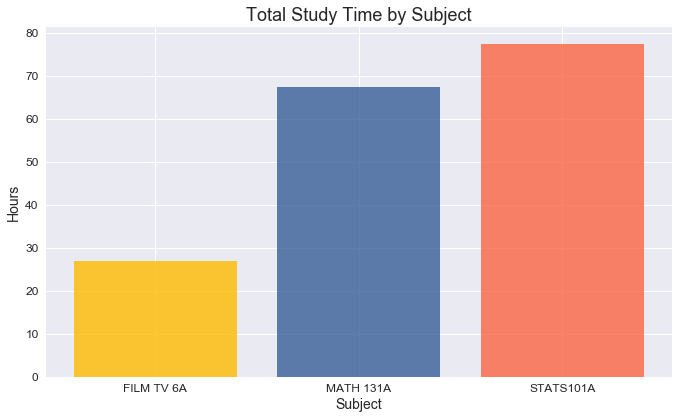

In [148]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

g1 = ax1.bar(subjects, total_times, color=primary_colors, alpha=0.8);

ax1.set_title("Total Study Time by Subject")
ax1.set_xlabel("Subject")
ax1.set_ylabel("Hours")

plt.show()

In [137]:
math_data = general_f17.loc[general_f17['Studying_Math']]
stats_data = general_f17.loc[general_f17['Studying_Stats']]
film_data = general_f17.loc[general_f17['Studying_Film']]